# Image Classification

This code shows how images, specifically vehicle images like cars, trucks, vans, bikes, motorcycles and others, can be classified using Convolutional Neural Network (CNN). This code is built based on an image classifier developed for the "Applied Data Science: Machine Learning" Program from the EPFL Lausanne.
The dataset consists of Swissroads data set which contains several hundreds images of vehicles found in the EPFL - Lausanne area including cars, trucks, vans, bikes, motorcycles and others. The dataset is quite small, hence the results, but could easily be extended to include other datasets and other vehicles classes.

In [159]:
# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# keras imports
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras import backend as K 


import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import pandas as pd
import itertools

import cv2
from PIL import Image

In [62]:
BATCH_SIZE = 16
EPOCHS = 500
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 6
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
LEARNING_RATE = 1e-4

In [3]:
base_dir = os.getcwd()  # Get the current working directory
data_dir = os.path.join(base_dir, 'swissroads')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
valid_dir = os.path.join(data_dir, 'valid')

***
**Utility functions**
***

In [4]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'], color = colors[n], label = 'Train ' + label)
    plt.semilogy(history.epoch,  history.history['val_loss'], color = colors[n], label = 'Val ' + label, linestyle = "--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

In [6]:
def plot_accuracy(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['accuracy'], color = colors[n], label = 'Train ' + label)
    plt.semilogy(history.epoch,  history.history['val_accuracy'], color = colors[n], label = 'Val ' + label, linestyle = "--")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
  
    plt.legend()

In [7]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch,  history.history[metric], color = colors[0], label = 'Train')
        plt.plot(history.epoch, history.history['val_' + metric], color = colors[1], linestyle = "--", label = 'Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])
        plt.legend()

In [8]:
def cspace_transf(image):
    image = np.array(image)
    return cv2.cvtColor(image,cv2.COLOR_RGB2XYZ)

***
**Using image data augmentation**
***


Overfitting is more likely to occur with a small number of samples and data augmentation seeks to improve this by providing additional data, based on the originals, with random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

The ImageDataGenerator transforms and rescale the images before putting them into a revised dataset. Rescaling gives all pixel channes a value from 0 to 255.

Here, I applied rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [9]:
# apply data augmentation to improve overfitting
train_image_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    brightness_range=[0.2,1.0],
                    zoom_range=0.5,
                    channel_shift_range=150.0,
                    fill_mode='nearest'
) # Generator for our training data

In [31]:
# apply data augmentation to improve overfitting
train_image_generator_cspace = ImageDataGenerator(
                    rescale=1./255,
                    preprocessing_function = cspace_transf,
) # Generator for our training data

***
**Standardizing the data**
***
Our image are already in a standard size (256x256), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general we should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

In [32]:
# only rescale, as we want our model to predict on real world images
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our test data

***
**Data pre-processing**
***
In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class. This class allows to:

- configure random transformations and normalization operations to be done on your image data during training
- instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.

In [33]:
train_data_gen = train_image_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                           directory = train_dir,
                                                           shuffle = True,
                                                           target_size = IMG_SIZE,
                                                           class_mode = 'categorical')

Found 280 images belonging to 6 classes.


In [34]:
train_data_gen_cspace = train_image_generator_cspace.flow_from_directory(batch_size = BATCH_SIZE,
                                                           directory = train_dir,
                                                           shuffle = True,
                                                           target_size = IMG_SIZE,
                                                           class_mode = 'categorical')

Found 280 images belonging to 6 classes.


In [35]:
valid_data_gen = validation_image_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                           directory = valid_dir,
                                                           shuffle = True,
                                                           target_size = IMG_SIZE,
                                                           class_mode = 'categorical')

Found 139 images belonging to 6 classes.


In [36]:
test_data_gen = test_image_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                           directory = test_dir,
                                                           shuffle = True,
                                                           target_size = IMG_SIZE,
                                                           class_mode = 'categorical')

Found 50 images belonging to 6 classes.


This part is to check the data format i.e if the RGB channel is coming first or last so that whatever it may be, the model will first check and then get the appropriate input shape be fed accordingly.

In [37]:
if K.image_data_format() == 'channels_first': 
    input_shape = (3, IMG_WIDTH, IMG_HEIGHT) 
else: 
    input_shape = (IMG_WIDTH, IMG_HEIGHT, 3) 

***
**Build the model**
***

The right tool for an image classification job is a convnet, so let's try to train one on our data, as an initial baseline. Since we only have few examples, our number one concern should be overfitting. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three, images of people who are sailors, and among them only one lumberjack wears a cap, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Data augmentation is one way to fight overfitting, but it isn't enough since our augmented samples are still highly correlated. Your main focus for fighting overfitting should be the entropic capacity of your model --how much information your model is allowed to store. A model that can store a lot of information has the potential to be more accurate by leveraging more features, but it is also more at risk to start storing irrelevant features. Meanwhile, a model that can only store a few features will have to focus on the most significant features found in the data, and these are more likely to be truly relevant and to generalize better.

There are different ways to modulate entropic capacity. The main one is the choice of the number of parameters in the model, i.e. the number of layers and the size of each layer. Another way is the use of weight regularization, such as L1 or L2 regularization, which consists in forcing model weights to taker smaller values.


The architectural decisions we will be making are the number of layers, the number of filters, and the size of the filters. In our case we will use a rather small convnet with few layers and few filters per layer, alongside data augmentation and dropout. Dropout also helps reduce overfitting, by preventing a layer from seeing twice the exact same pattern, thus acting in a way analoguous to data augmentation (you could say that both dropout and data augmentation tend to disrupt random correlations occuring in the data). 

This is very similar to the architectures that Yann LeCun advocated in the 1990s for image classification (with the exception of ReLU).

- **Conv2D** is the layer to convolve the image into multiple images
- **Activation** is the activation function.
- **MaxPooling2D** is used to max pool the value from the given size matrix and same is used for the next 2 layers. then, Flatten is used to flatten the dimensions of the image obtained after convolving it.
- **Dense** is used to make this a fully connected model and is the hidden layer.
- **Dropout** is used to avoid overfitting on the dataset.
- **Dense** is the output layer contains only one neuron which decide to which category image belongs.

Typically the number of layers starts small and grows as the complexity realized by the convoluted layers grows. The number of filters in a layer should be set at ratios of 32, 64, 128, 256, 512 and so on according to one source. In this case I have elected to make four convolutional layers with succeeding filter sizes of 16, 32, 64, 128.

Filters have odd values since they need to be centered on the pixel being convolved. A 3x3 filter is usual although larger ones of 5x5 up to 7x7 may work better on larger images. After multiple trials and experiements I decided to go a considerably bigger filter of 11x11. The reason for this is that for this particular image set, a big number of pixels is probably necessary for the network recognize the object (the objects occupy a very part of the image). Max pool layers typically have a pool size of (2, 2) and are applied after each convolutional layer.

After flattening I chose to set dropout to 0.1 and 0.5 respectively. 

The model was given a single dense layer with 128 neurons with activation set to 'relu' as usual. The number of output elements is always set to the number of classes and activation to 'softmax'.

In [188]:
def make_model():
        
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(11, 11), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.3))

    model.add(BatchNormalization())

    model.add(Conv2D(32, (11, 11), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.3))

    model.add(BatchNormalization())

    model.add(Conv2D(64, (11, 11), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.3))

    model.add(BatchNormalization())

    model.add(Conv2D(128, (11, 11), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.3))

    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = 1e-5), metrics=['accuracy'])

    return model

***
**Model Architecture**
***

**Early stopping**

When we’re training a learning algorithm iteratively, we can measure how well each iteration of the model performs. Up until a certain number of iterations, new iterations improve the model. After that point, however, the model’s ability to generalize can weaken as it begins to overfit the training data. Early stopping refers stopping the training process before the learner passes that point.

In [189]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy', 
    verbose = 2,
    patience = 30,
    mode = 'max',
    restore_best_weights = True)

In [190]:
reduce_lr_acc = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.1, 
    patience=50, 
    verbose=2, 
#     min_delta=1e-4, 
    cooldown=1,
    mode='auto')

In [191]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('model_best.h5', 
                           save_best_only=True, 
                           monitor='val_accuracy', 
                           mode='max')

In [192]:
callbacks_2 = [early_stopping, reduce_lr_acc]

In [193]:
callbacks = [reduce_lr_acc]

***
**Train the model**
***

In [194]:
TRAIN_STEPS = int(np.ceil(train_data_gen.n / float(BATCH_SIZE)))

In [195]:
VALIDATION_STEPS = int(np.ceil(valid_data_gen.n / float(BATCH_SIZE)))

In [196]:
TEST_STEPS = int(np.ceil(test_data_gen.n / float(BATCH_SIZE)))

In [197]:
model = make_model()
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 256, 256, 16)      5824      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization_58 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 128, 128, 32)      61984     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_59 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 64, 64, 64)      

In [198]:
history = model.fit( 
    train_data_gen, 
    steps_per_epoch = TRAIN_STEPS, 
    epochs = EPOCHS*2,
#     callbacks = callbacks, 
    validation_data = valid_data_gen, 
    validation_steps = VALIDATION_STEPS) 

Epoch 1/1000
18/18 [==============================] - 127s 7s/step - loss: 2.9614 - accuracy: 0.1841 - val_loss: 1.7805 - val_accuracy: 0.2374
Epoch 2/1000
18/18 [==============================] - 152s 8s/step - loss: 2.5336 - accuracy: 0.1862 - val_loss: 1.7684 - val_accuracy: 0.2302
Epoch 3/1000
18/18 [==============================] - 134s 7s/step - loss: 2.5734 - accuracy: 0.2217 - val_loss: 1.7669 - val_accuracy: 0.2158
Epoch 4/1000
18/18 [==============================] - 108s 6s/step - loss: 2.4624 - accuracy: 0.1843 - val_loss: 1.7575 - val_accuracy: 0.2590
Epoch 5/1000
18/18 [==============================] - 107s 6s/step - loss: 2.2050 - accuracy: 0.2189 - val_loss: 1.7520 - val_accuracy: 0.2374
Epoch 6/1000
18/18 [==============================] - 106s 6s/step - loss: 2.2728 - accuracy: 0.2165 - val_loss: 1.7392 - val_accuracy: 0.2374
Epoch 7/1000
18/18 [==============================] - 113s 6s/step - loss: 2.1976 - accuracy: 0.2156 - val_loss: 1.7412 - val_accuracy: 0.2374

Epoch 58/1000
18/18 [==============================] - 106s 6s/step - loss: 1.6048 - accuracy: 0.3704 - val_loss: 1.4195 - val_accuracy: 0.4388
Epoch 59/1000
18/18 [==============================] - 101s 6s/step - loss: 1.6722 - accuracy: 0.3379 - val_loss: 1.4973 - val_accuracy: 0.4173
Epoch 60/1000
18/18 [==============================] - 100s 6s/step - loss: 1.6291 - accuracy: 0.3631 - val_loss: 1.4328 - val_accuracy: 0.3813
Epoch 61/1000
18/18 [==============================] - 101s 6s/step - loss: 1.6056 - accuracy: 0.3960 - val_loss: 1.4066 - val_accuracy: 0.4245
Epoch 62/1000
18/18 [==============================] - 101s 6s/step - loss: 1.6812 - accuracy: 0.3072 - val_loss: 1.4272 - val_accuracy: 0.4317
Epoch 63/1000
18/18 [==============================] - 101s 6s/step - loss: 1.5108 - accuracy: 0.4258 - val_loss: 1.4389 - val_accuracy: 0.4173
Epoch 64/1000
18/18 [==============================] - 110s 6s/step - loss: 1.7189 - accuracy: 0.2789 - val_loss: 1.4540 - val_accuracy:

Epoch 115/1000
18/18 [==============================] - 105s 6s/step - loss: 1.4945 - accuracy: 0.4067 - val_loss: 1.2634 - val_accuracy: 0.5180
Epoch 116/1000
18/18 [==============================] - 106s 6s/step - loss: 1.5338 - accuracy: 0.4126 - val_loss: 1.3326 - val_accuracy: 0.4892
Epoch 117/1000
18/18 [==============================] - 106s 6s/step - loss: 1.5183 - accuracy: 0.3895 - val_loss: 1.2788 - val_accuracy: 0.5468
Epoch 118/1000
18/18 [==============================] - 104s 6s/step - loss: 1.5143 - accuracy: 0.4067 - val_loss: 1.2865 - val_accuracy: 0.5180
Epoch 119/1000
18/18 [==============================] - 113s 6s/step - loss: 1.4738 - accuracy: 0.4319 - val_loss: 1.2940 - val_accuracy: 0.4748
Epoch 120/1000
18/18 [==============================] - 105s 6s/step - loss: 1.4627 - accuracy: 0.4603 - val_loss: 1.2716 - val_accuracy: 0.5612
Epoch 121/1000
18/18 [==============================] - 105s 6s/step - loss: 1.5194 - accuracy: 0.3871 - val_loss: 1.2708 - val_ac

18/18 [==============================] - 131s 7s/step - loss: 1.3544 - accuracy: 0.4182 - val_loss: 1.1384 - val_accuracy: 0.6187
Epoch 228/1000
18/18 [==============================] - 131s 7s/step - loss: 1.2358 - accuracy: 0.5057 - val_loss: 1.1345 - val_accuracy: 0.6043
Epoch 229/1000
18/18 [==============================] - 119s 7s/step - loss: 1.3024 - accuracy: 0.4966 - val_loss: 1.1427 - val_accuracy: 0.5899
Epoch 230/1000
18/18 [==============================] - 121s 7s/step - loss: 1.2620 - accuracy: 0.4917 - val_loss: 1.2546 - val_accuracy: 0.5683
Epoch 231/1000
18/18 [==============================] - 123s 7s/step - loss: 1.2813 - accuracy: 0.5414 - val_loss: 1.1250 - val_accuracy: 0.5468
Epoch 232/1000
18/18 [==============================] - 140s 8s/step - loss: 1.3008 - accuracy: 0.4710 - val_loss: 1.1258 - val_accuracy: 0.5899
Epoch 233/1000
18/18 [==============================] - 143s 8s/step - loss: 1.3085 - accuracy: 0.5130 - val_loss: 1.1383 - val_accuracy: 0.5683


18/18 [==============================] - 111s 6s/step - loss: 1.2060 - accuracy: 0.5576 - val_loss: 1.0761 - val_accuracy: 0.5971
Epoch 340/1000
18/18 [==============================] - 105s 6s/step - loss: 1.1873 - accuracy: 0.5461 - val_loss: 1.1061 - val_accuracy: 0.6115
Epoch 341/1000
18/18 [==============================] - 105s 6s/step - loss: 1.1444 - accuracy: 0.5346 - val_loss: 1.0419 - val_accuracy: 0.6259
Epoch 342/1000
18/18 [==============================] - 104s 6s/step - loss: 1.1456 - accuracy: 0.5607 - val_loss: 1.0578 - val_accuracy: 0.6403
Epoch 343/1000
18/18 [==============================] - 104s 6s/step - loss: 1.2613 - accuracy: 0.5385 - val_loss: 1.1033 - val_accuracy: 0.6475
Epoch 344/1000
18/18 [==============================] - 104s 6s/step - loss: 1.3239 - accuracy: 0.4997 - val_loss: 1.1020 - val_accuracy: 0.6259
Epoch 345/1000
18/18 [==============================] - 110s 6s/step - loss: 1.1714 - accuracy: 0.5439 - val_loss: 1.1041 - val_accuracy: 0.5899


Epoch 396/1000
18/18 [==============================] - 98s 5s/step - loss: 1.2752 - accuracy: 0.5519 - val_loss: 1.0726 - val_accuracy: 0.5899
Epoch 397/1000
18/18 [==============================] - 104s 6s/step - loss: 1.1422 - accuracy: 0.5503 - val_loss: 1.0658 - val_accuracy: 0.6043
Epoch 398/1000
18/18 [==============================] - 98s 5s/step - loss: 1.1345 - accuracy: 0.5413 - val_loss: 1.0751 - val_accuracy: 0.6403
Epoch 399/1000
18/18 [==============================] - 98s 5s/step - loss: 1.1500 - accuracy: 0.5397 - val_loss: 1.1316 - val_accuracy: 0.6043
Epoch 400/1000
18/18 [==============================] - 98s 5s/step - loss: 1.2226 - accuracy: 0.5340 - val_loss: 1.1363 - val_accuracy: 0.5971
Epoch 401/1000
18/18 [==============================] - 98s 5s/step - loss: 1.0970 - accuracy: 0.5519 - val_loss: 1.1303 - val_accuracy: 0.6115
Epoch 402/1000
18/18 [==============================] - 104s 6s/step - loss: 1.1533 - accuracy: 0.5583 - val_loss: 1.1366 - val_accurac

Epoch 453/1000
18/18 [==============================] - 98s 6s/step - loss: 1.1465 - accuracy: 0.5475 - val_loss: 1.3317 - val_accuracy: 0.6115
Epoch 454/1000
18/18 [==============================] - 99s 5s/step - loss: 1.1567 - accuracy: 0.5119 - val_loss: 1.0958 - val_accuracy: 0.6403
Epoch 455/1000
18/18 [==============================] - 99s 5s/step - loss: 1.0424 - accuracy: 0.5938 - val_loss: 1.1054 - val_accuracy: 0.6403
Epoch 456/1000
18/18 [==============================] - 98s 5s/step - loss: 1.1182 - accuracy: 0.5739 - val_loss: 1.1117 - val_accuracy: 0.6331
Epoch 457/1000
18/18 [==============================] - 107s 6s/step - loss: 1.0537 - accuracy: 0.6192 - val_loss: 1.1102 - val_accuracy: 0.6259
Epoch 458/1000
18/18 [==============================] - 98s 5s/step - loss: 1.0071 - accuracy: 0.6178 - val_loss: 1.1865 - val_accuracy: 0.5827
Epoch 459/1000
18/18 [==============================] - 98s 5s/step - loss: 1.2816 - accuracy: 0.5150 - val_loss: 1.0750 - val_accuracy

Epoch 510/1000
18/18 [==============================] - 98s 5s/step - loss: 0.9917 - accuracy: 0.6112 - val_loss: 1.3626 - val_accuracy: 0.6043
Epoch 511/1000
18/18 [==============================] - 115s 6s/step - loss: 1.1216 - accuracy: 0.6023 - val_loss: 1.1784 - val_accuracy: 0.6115
Epoch 512/1000
18/18 [==============================] - 98s 5s/step - loss: 0.9607 - accuracy: 0.6450 - val_loss: 1.2287 - val_accuracy: 0.6547
Epoch 513/1000
18/18 [==============================] - 98s 5s/step - loss: 1.1265 - accuracy: 0.5659 - val_loss: 1.1351 - val_accuracy: 0.6475
Epoch 514/1000
18/18 [==============================] - 98s 5s/step - loss: 1.0304 - accuracy: 0.6161 - val_loss: 1.1753 - val_accuracy: 0.6331
Epoch 515/1000
18/18 [==============================] - 98s 5s/step - loss: 1.1289 - accuracy: 0.5845 - val_loss: 1.1758 - val_accuracy: 0.6259
Epoch 516/1000
18/18 [==============================] - 98s 5s/step - loss: 1.1293 - accuracy: 0.5834 - val_loss: 1.1370 - val_accuracy

Epoch 567/1000
18/18 [==============================] - 113s 6s/step - loss: 0.9566 - accuracy: 0.6437 - val_loss: 1.1120 - val_accuracy: 0.6331
Epoch 568/1000
18/18 [==============================] - 102s 6s/step - loss: 1.0459 - accuracy: 0.5633 - val_loss: 1.1169 - val_accuracy: 0.6331
Epoch 569/1000
18/18 [==============================] - 105s 6s/step - loss: 1.0668 - accuracy: 0.5876 - val_loss: 1.1271 - val_accuracy: 0.6547
Epoch 570/1000
18/18 [==============================] - 113s 6s/step - loss: 1.0150 - accuracy: 0.6471 - val_loss: 1.0811 - val_accuracy: 0.6547
Epoch 571/1000
18/18 [==============================] - 106s 6s/step - loss: 1.0060 - accuracy: 0.6174 - val_loss: 1.1512 - val_accuracy: 0.6547
Epoch 572/1000
18/18 [==============================] - 106s 6s/step - loss: 1.0861 - accuracy: 0.5651 - val_loss: 1.0552 - val_accuracy: 0.6619
Epoch 573/1000
18/18 [==============================] - 106s 6s/step - loss: 1.0794 - accuracy: 0.6058 - val_loss: 1.0912 - val_ac

18/18 [==============================] - 103s 6s/step - loss: 0.9073 - accuracy: 0.6328 - val_loss: 1.1871 - val_accuracy: 0.6043
Epoch 680/1000
18/18 [==============================] - 113s 6s/step - loss: 0.9514 - accuracy: 0.5965 - val_loss: 1.3286 - val_accuracy: 0.6475
Epoch 681/1000
18/18 [==============================] - 103s 6s/step - loss: 1.0236 - accuracy: 0.6343 - val_loss: 1.1285 - val_accuracy: 0.6403
Epoch 682/1000
18/18 [==============================] - 106s 6s/step - loss: 1.0029 - accuracy: 0.6059 - val_loss: 1.1896 - val_accuracy: 0.6403
Epoch 683/1000
18/18 [==============================] - 107s 6s/step - loss: 1.1332 - accuracy: 0.6416 - val_loss: 1.0746 - val_accuracy: 0.6475
Epoch 684/1000
18/18 [==============================] - 103s 6s/step - loss: 1.0096 - accuracy: 0.6458 - val_loss: 1.0752 - val_accuracy: 0.6475
Epoch 685/1000
18/18 [==============================] - 103s 6s/step - loss: 0.9823 - accuracy: 0.6296 - val_loss: 1.1385 - val_accuracy: 0.6475


18/18 [==============================] - 100s 6s/step - loss: 0.8764 - accuracy: 0.6938 - val_loss: 1.0980 - val_accuracy: 0.6403
Epoch 792/1000
18/18 [==============================] - 127s 7s/step - loss: 0.8156 - accuracy: 0.6365 - val_loss: 1.1148 - val_accuracy: 0.6187
Epoch 793/1000
18/18 [==============================] - 126s 7s/step - loss: 0.9090 - accuracy: 0.6717 - val_loss: 1.1034 - val_accuracy: 0.6547
Epoch 794/1000
18/18 [==============================] - 106s 6s/step - loss: 0.8088 - accuracy: 0.7064 - val_loss: 1.1300 - val_accuracy: 0.6763
Epoch 795/1000
18/18 [==============================] - 102s 6s/step - loss: 0.9119 - accuracy: 0.6291 - val_loss: 1.1573 - val_accuracy: 0.6835
Epoch 796/1000
18/18 [==============================] - 102s 6s/step - loss: 0.9121 - accuracy: 0.7376 - val_loss: 1.2032 - val_accuracy: 0.6619
Epoch 797/1000
18/18 [==============================] - 103s 6s/step - loss: 0.9274 - accuracy: 0.6589 - val_loss: 1.2126 - val_accuracy: 0.6619


18/18 [==============================] - 109s 6s/step - loss: 0.9158 - accuracy: 0.6544 - val_loss: 1.1303 - val_accuracy: 0.6547
Epoch 904/1000
18/18 [==============================] - 105s 6s/step - loss: 0.8094 - accuracy: 0.6751 - val_loss: 1.2247 - val_accuracy: 0.6906
Epoch 905/1000
18/18 [==============================] - 104s 6s/step - loss: 0.7650 - accuracy: 0.7055 - val_loss: 1.3025 - val_accuracy: 0.6259
Epoch 906/1000
18/18 [==============================] - 107s 6s/step - loss: 0.8534 - accuracy: 0.7093 - val_loss: 1.1216 - val_accuracy: 0.6978
Epoch 907/1000
18/18 [==============================] - 105s 6s/step - loss: 0.8003 - accuracy: 0.7086 - val_loss: 1.0962 - val_accuracy: 0.6619
Epoch 908/1000
18/18 [==============================] - 105s 6s/step - loss: 0.8633 - accuracy: 0.6763 - val_loss: 1.1629 - val_accuracy: 0.6835
Epoch 909/1000
18/18 [==============================] - 114s 6s/step - loss: 0.7568 - accuracy: 0.7064 - val_loss: 1.1563 - val_accuracy: 0.6835


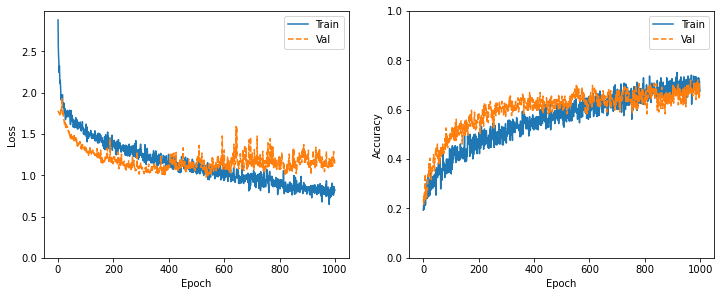

In [199]:
plot_metrics(history)

The network took a very long time to train, and it is obvious that even more epochs can improve the performance, as the tendency is for the accuracy to still increase, and the loss to still decrease respectively.

In [200]:
model.save("cnn_opt_11_11.h5")
print("Saved model to disk")

Saved model to disk


In [201]:
# evaluate model on validation data
score = model.evaluate(valid_data_gen, steps = VALIDATION_STEPS, verbose = 2)

9/9 - 12s - loss: 1.1181 - accuracy: 0.6475


In [202]:
print(f'Validation loss: {score[0]} / Validation accuracy: {score[1]}')

Validation loss: 1.118070125579834 / Validation accuracy: 0.6474820375442505


In [203]:
# evaluate model on test data
score = model.evaluate(test_data_gen, steps = TEST_STEPS, verbose = 2)

4/4 - 4s - loss: 1.2262 - accuracy: 0.6400


In [204]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.2261955738067627 / Test accuracy: 0.6399999856948853


In [205]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [206]:
predictions = model.predict(test_data_gen, steps = TEST_STEPS)

In [207]:
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

In [208]:
# Get ground-truth classes and class-labels
true_classes = test_data_gen.classes
class_labels = list(test_data_gen.class_indices.keys())   

In [209]:
report = classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

        bike       0.38      0.42      0.40        12
         car       0.35      0.55      0.43        11
  motorcycle       0.00      0.00      0.00         9
       other       0.00      0.00      0.00         6
       truck       0.09      0.14      0.11         7
         van       0.00      0.00      0.00         5

    accuracy                           0.24        50
   macro avg       0.14      0.18      0.16        50
weighted avg       0.18      0.24      0.21        50



In [210]:
matrix = confusion_matrix(test_data_gen.classes, predicted_classes)
print(matrix)

[[5 1 2 0 4 0]
 [4 6 0 0 0 1]
 [1 3 0 1 3 1]
 [0 3 1 0 2 0]
 [1 2 2 0 1 1]
 [2 2 0 0 1 0]]


In [161]:
train_predictions = model.predict(train_data_gen, steps = TRAIN_STEPS)

/Users/laura/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [162]:
# Get most likely class
train_predicted_classes = np.argmax(train_predictions, axis=1)

In [163]:
# Get ground-truth classes and class-labels
train_true_classes = train_data_gen.classes
train_class_labels = list(train_data_gen.class_indices.keys())   

In [ ]:
train_class_labels

In [164]:
train_predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [165]:
train_true_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)